#Imports

In [ ]:
import torch
import torch.nn as nn
# plot the accuracy heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
# add pd to the path
import sys
# import pandas
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  ConfusionMatrixDisplay,confusion_matrix
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
from google.colab import files
import io
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
import re
from pandas import Series,DataFrame
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
!pip install transformers
from transformers import BertTokenizer
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 46.8 MB/s eta 0:00:00


#Data Loading

In [ ]:
# mount drive from google drive to colab using https://drive.google.com/file/d/1zbCL7aktBqAgndgkvinI27XntHxfoGHn/view?usp=share_link
from google.colab import drive
drive.mount('/content/drive')
# read data from google drive
import pandas as pd
read_data = pd.read_csv('/content/drive/My Drive/IMDB Dataset.csv')


Mounted at /content/drive


In [ ]:
read_data['sentiment'].value_counts()
# print the number of instances of each class
print(read_data['sentiment'].value_counts())
read_data.describe()

positive    25000
negative    25000
Name: sentiment, dtype: int64


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
read_data.dropna(axis = 0, how = 'any', inplace = True)
read_data.to_csv('IMDB Dataset_parsed.csv', index = False)

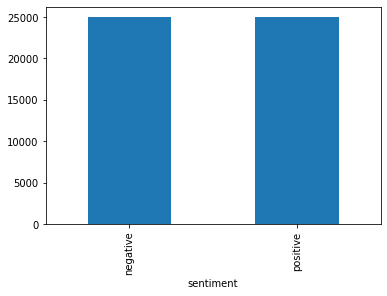

In [ ]:
read_data.groupby(['sentiment']).size().plot.bar()

#Balancing dataset

In [ ]:
# get the indices of the majority class positive
indices = read_data[read_data['sentiment'] == 'positive'].index

# get the size of the minority class negative
sizen = len(read_data[read_data['sentiment'] == 'negative'])
sizep = len(read_data[read_data['sentiment'] == 'positive'])

# randomly sample the indices of the majority class positive
indices = np.random.choice(indices, sizen-sizep, replace=False)

# delete from the majority class g
read_data = read_data.drop(indices)
print(read_data['sentiment'].value_counts())
read_data.describe()

positive    25000
negative    25000
Name: sentiment, dtype: int64


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


#Splitting the data

In [ ]:
# split into features and labels
features = read_data.drop(columns='sentiment')
labels = read_data['sentiment']
# split into training and test sets
X_train, X_t, y_train, y_t = train_test_split(features, labels, test_size=0.3, random_state=0, stratify=labels,shuffle=True)
# print the number of instances of each class in the training set

# print the number of instances of each class in the test set
y_train.value_counts()
# print(labels_test['class'].value_counts())
#labels_train.describe()

positive    17500
negative    17500
Name: sentiment, dtype: int64

In [ ]:
X_validate, X_test, y_validate, y_test = train_test_split(X_t,y_t, test_size=2/3, random_state=0, stratify=y_t,shuffle=True)
print(y_test.value_counts())
print(y_validate.value_counts())

negative    5000
positive    5000
Name: sentiment, dtype: int64
positive    2500
negative    2500
Name: sentiment, dtype: int64


In [ ]:
train_list = [] 
test_list = []
val_list = []
grouped_df = read_data.groupby('sentiment')

# ITERATE THROUGH EACH SUBSET DF
for i, g in grouped_df:
    # STRATIFY THE g (CLASS) DATA FRAME
    train, test, val = np.split(g, [int(.7 * len(g)), int(.9 * len(g))])

    train_list.append(train); test_list.append(test); val_list.append(val)

train_data = pd.concat(train_list)
test_data = pd.concat(test_list)
validation_data = pd.concat(val_list)

In [ ]:
# np.random.seed(112)
# train_data, test_data, validation_data = np.split(read_data.sample(frac=1, random_state=42), 
#                                      [int(.7*len(read_data)), int(.9*len(read_data))])

# print(len(train_data),len(validation_data), len(test_data))

In [ ]:
print(train_data['sentiment'].value_counts())


negative    17500
positive    17500
Name: sentiment, dtype: int64


In [ ]:
print(test_data['sentiment'].value_counts())


negative    5000
positive    5000
Name: sentiment, dtype: int64


In [ ]:
print(validation_data['sentiment'].value_counts())


negative    2500
positive    2500
Name: sentiment, dtype: int64


#Text Pre-processing

In [ ]:
def remove_html_tags(data):
    """Remove html tags from a string"""
    for w in data:
      clean = re.compile('<.*?>')
    return re.sub(clean, '', data)

In [ ]:
X_train['review'] = X_train['review'].apply(remove_html_tags)
X_train.head()

,review
24048,ThirstI found that this film was beautifully c...
3055,Trio's vignettes were insightful and quite enj...
1381,"How viewers react to this new ""adaption"" of Sh..."
40039,This must rank as one of Cinema's greatest deb...
5457,A quick paced and entertaining noir set in Vie...


##Lower characters

In [ ]:
#lowercase characters 
X_train['review']=X_train['review'].str.lower()
X_train.head()

,review
24048,thirsti found that this film was beautifully c...
3055,trio's vignettes were insightful and quite enj...
1381,"how viewers react to this new ""adaption"" of sh..."
40039,this must rank as one of cinema's greatest deb...
5457,a quick paced and entertaining noir set in vie...


##Remove punctuations

In [ ]:
#function to remove punctuation
import string
def remove_punc(data):
  trans = str.maketrans("'"," ",'!"#$%&()*+,-./:;<=>?@[\]^_`{|}~' )
  return data.translate(trans)

In [ ]:
#applying function on the dataset
X_train['review'] = X_train['review'].apply(remove_punc)
X_train['review']=X_train['review'].apply(lambda X: word_tokenize(X))
X_train.head()

,review
24048,"[thirsti, found, that, this, film, was, beauti..."
3055,"[trio, s, vignettes, were, insightful, and, qu..."
1381,"[how, viewers, react, to, this, new, adaption,..."
40039,"[this, must, rank, as, one, of, cinema, s, gre..."
5457,"[a, quick, paced, and, entertaining, noir, set..."


##Lemmatization

In [ ]:
#Lemmatization function
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
    return text

In [ ]:
# note we should use lemmatized_output = ' '.join(lemmatizer.lemmatize(w) for w in \  
#                                    w_tokenizer.tokenize((text)) if len(w) >4 ) 
# because it removed the s in was

In [ ]:
#Lemmatization of words
X_train['review'] = X_train['review'].apply(lemmatize)
X_train.head()

,review
24048,"[thirsti, found, that, this, film, wa, beautif..."
3055,"[trio, s, vignette, were, insightful, and, qui..."
1381,"[how, viewer, react, to, this, new, adaption, ..."
40039,"[this, must, rank, a, one, of, cinema, s, grea..."
5457,"[a, quick, paced, and, entertaining, noir, set..."


##Remove stop words

In [ ]:
#Remove stopwords function
def remove_stopWords(data):
  stop_words = set(stopwords.words('english'))
  #with no lower case conversion
  filtered_sentence = []
  for w in data:
      if w not in stop_words:
          filtered_sentence.append(w)
  return filtered_sentence

In [ ]:
X_train['review'] = X_train['review'].apply(remove_stopWords)
X_train.head()

,review
24048,"[thirsti, found, film, wa, beautifully, crafte..."
3055,"[trio, vignette, insightful, quite, enjoyable,..."
1381,"[viewer, react, new, adaption, shirley, jackso..."
40039,"[must, rank, one, cinema, greatest, debacle, w..."
5457,"[quick, paced, entertaining, noir, set, vienna..."


In [ ]:
def preprocess(data):
    data = data.apply(remove_html_tags)
    data = data.str.lower()
    data = data.apply(remove_punc)
    data = data.apply(lambda X: word_tokenize(X))

    data= data.apply(lemmatize)
    data= data.apply(remove_stopWords)

#BERT


## Dataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'positive':0,
          'negative':1,
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['sentiment']]
        df['review']=df['review'].apply(remove_html_tags)
        df['review']=df['review'].str.lower()
        df['review'] = df['review'].apply(remove_punc)
        df['review'] = df['review'].apply(lambda X: word_tokenize(X))
        df['review'] = df['review'].apply(lemmatize)
        df['review'] = df['review'].apply(remove_stopWords)
        # untokenize the text
        df['review'] = df['review'].apply(lambda x: ' '.join(x))
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['review']]
        # text preprocessing
        

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y
    # def remove_html_tags(self):
    #     """Remove html tags from a string"""
    #     for w in self.texts:
    #       clean = re.compile('<.*?>')
    #     return re.sub(clean, '', self.texts)
    
    # def remove_punctuation(self):
    #     """Remove punctuation from a string"""
    #     return self.texts.translate(str.maketrans('', '', string.punctuation))
    
    # def lowercase(self):
    #     """Lowercase a string"""
    #     return self.texts.lower()
    
    # def remove_stopwords(self):
    #     """Remove stopwords from a string"""
    #     return ' '.join([word for word in self.texts.split() if word not in (stopwords.words('english'))])

    # def lemmatize(self):
    #     """Lemmatize a string"""
    #     return ' '.join([WordNetLemmatizer().lemmatize(word) for word in self.texts.split()])


## Model

In [ ]:
from torch.nn.modules import linear
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout_1 = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(768,512)
        self.dropout_2 = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(512, 256)
        self.dropout_3 = nn.Dropout(dropout)
        self.linear_3 = nn.Linear(256, 128)
        self.dropout_4 = nn.Dropout(dropout)
        self.linear_4= nn.Linear(128, 64)
        self.dropout_5 = nn.Dropout(dropout)
        self.linear_5= nn.Linear(64, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout_1(pooled_output)
        linear_output_1 = self.linear_1(dropout_output)
        dropout_output_1 = self.dropout_2(linear_output_1)
        linear_output_2 = self.linear_2(dropout_output_1)
        dropout_output_2 = self.dropout_3(linear_output_2)
        linear_output_3 = self.linear_3(dropout_output_2)
        dropout_output_3 = self.dropout_4(linear_output_3)
        linear_output_4 = self.linear_4(dropout_output_3)
        dropout_output_4 = self.dropout_5(linear_output_4)
        linear_output_5 = self.linear_5(dropout_output_4)
        final_layer = self.relu(linear_output_5)

        return final_layer

In [ ]:
import shutil, sys   
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

# Loss as a metric

In [ ]:
epochs = [1,2,3,4,5]
test_acc =[]
val_acc=[]

from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs,checkpoint_path , best_model_path , valid_loss_min_input):
    test_acc.clear()
    val_acc.clear()
    valid_loss_min = valid_loss_min_input 
    train, val = Dataset(train_data), Dataset(val_data)
    # preprocess the data
    # train.preprocess()
    # val.preprocess()
    

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=4)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in epochs:
            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                # train_label_squeeze = train_label
                # train_label = train_label.unsqueeze(1)
                # train_label = train_label.float()
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)
                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num } | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            test_acc.append(total_acc_train / len(train_data))
            val_acc.append(total_acc_val / len(val_data))
          
            valid_loss = total_loss_val/len(val_data)
            checkpoint = {
                'epoch': epoch_num ,
                'valid_loss_min': valid_loss,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate
                }
            save_ckp(checkpoint, False, checkpoint_path, best_model_path)

            if valid_loss <= valid_loss_min:
              print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
              # save checkpoint as best model
              save_ckp(checkpoint, True, checkpoint_path, best_model_path)
              valid_loss_min = valid_loss
                  
# EPOCHS = 5
model = BertClassifier()
LR = 1e-6
checkpoint_path = '/content/drive/MyDrive/bert/checkpoints/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodel/model.pt'

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
EPOCHS =[1,2,3,4,5]
train(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model,np.Inf)

100%|██████████| 8750/8750 [58:13<00:00,  2.50it/s]


Epochs: 1 | Train Loss:  0.145                 | Train Accuracy:  0.693                 | Val Loss:  0.099                 | Val Accuracy:  0.863
Validation loss decreased (inf --> 0.098877).  Saving model ...


100%|██████████| 8750/8750 [58:21<00:00,  2.50it/s]


Epochs: 2 | Train Loss:  0.081                 | Train Accuracy:  0.889                 | Val Loss:  0.075                 | Val Accuracy:  0.889
Validation loss decreased (0.098877 --> 0.075061).  Saving model ...


100%|██████████| 8750/8750 [58:21<00:00,  2.50it/s]


Epochs: 3 | Train Loss:  0.059                 | Train Accuracy:  0.921                 | Val Loss:  0.073                 | Val Accuracy:  0.886
Validation loss decreased (0.075061 --> 0.073194).  Saving model ...


100%|██████████| 8750/8750 [58:25<00:00,  2.50it/s]


Epochs: 4 | Train Loss:  0.043                 | Train Accuracy:  0.950                 | Val Loss:  0.076                 | Val Accuracy:  0.894


100%|██████████| 8750/8750 [58:24<00:00,  2.50it/s]


Epochs: 5 | Train Loss:  0.028                 | Train Accuracy:  0.972                 | Val Loss:  0.089                 | Val Accuracy:  0.891


In [ ]:

def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    lr =  checkpoint['learning_rate']
    # return model, optimizer, epoch value, min validation loss , lr
    return model, optimizer, checkpoint['epoch'], valid_loss_min , lr

In [ ]:
model_lr5 = BertClassifier()
LR_lr5 = 1e-5
checkpoint_path_lr5 = '/content/drive/MyDrive/bert/checkpoints_lr1.e5/check.pt'
best_model_lr5 = '/content/drive/MyDrive/bert/bestmodel_lr1.e5/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
EPOCHS_lr5 =[1,2,3,4,5]
train(model_lr5, train_data, validation_data, LR_lr5, EPOCHS_lr5,checkpoint_path_lr5, best_model_lr5,np.Inf)

100%|██████████| 8750/8750 [53:46<00:00,  2.71it/s]


Epochs: 1 | Train Loss:  0.105                 | Train Accuracy:  0.790                 | Val Loss:  0.068                 | Val Accuracy:  0.894
Validation loss decreased (inf --> 0.067615).  Saving model ...


100%|██████████| 8750/8750 [53:57<00:00,  2.70it/s]


Epochs: 2 | Train Loss:  0.050                 | Train Accuracy:  0.927                 | Val Loss:  0.072                 | Val Accuracy:  0.897


100%|██████████| 8750/8750 [53:58<00:00,  2.70it/s]


Epochs: 3 | Train Loss:  0.023                 | Train Accuracy:  0.972                 | Val Loss:  0.077                 | Val Accuracy:  0.912


100%|██████████| 8750/8750 [53:55<00:00,  2.70it/s]


Epochs: 4 | Train Loss:  0.011                 | Train Accuracy:  0.989                 | Val Loss:  0.113                 | Val Accuracy:  0.910


100%|██████████| 8750/8750 [53:53<00:00,  2.71it/s]


Epochs: 5 | Train Loss:  0.008                 | Train Accuracy:  0.992                 | Val Loss:  0.111                 | Val Accuracy:  0.903


In [ ]:
# reload ckp and start training from the last epoch
model_lr5 = BertClassifier()
optimizer_lr5 = Adam(model.parameters(), lr= LR_lr5)
model_lr5, optimizer_lr5, start_epoch, valid_loss_min_lr5, LR_lr5 = load_ckp(checkpoint_path_lr5, model_lr5, optimizer_lr5)
EPOCHS_lr5 = range(start_epoch+1,8)
print(EPOCHS_lr5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


range(6, 8)


In [ ]:
train(model_lr5, train_data, validation_data, LR_lr5, EPOCHS_lr5,checkpoint_path_lr5, best_model_lr5, valid_loss_min_lr5)

 23%|██▎       | 1975/8750 [12:05<41:49,  2.70it/s]

# Accuracy as a metric

In [ ]:
# accuracy
def load_ckp_accuracy(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    valid_accuracy_max=checkpoint['valid_accuracy_max']
    lr =  checkpoint['learning_rate']
    # return model, optimizer, epoch value, min validation loss , lr
    return model, optimizer, checkpoint['epoch'], valid_accuracy_max , lr

In [ ]:
def load_model_accuracy(bestmodel_fpath, model, optimizer):
    """
    bestmodel_fpath: path to save best model
    model: model that we want to load best model parameters into
    optimizer: optimizer we defined in previous training
    """
    # load best model
    best_model = torch.load(bestmodel_fpath)
    # initialize state_dict from best model to model
    model.load_state_dict(best_model['state_dict'])
    # initialize optimizer from best model to optimizer
    optimizer.load_state_dict(best_model['optimizer'])
    # initialize valid_loss_min from best model to valid_loss_min
    valid_loss_min = best_model['valid_loss_min']
    valid_accuracy_max=best_model['valid_accuracy_max']
    lr =  best_model['learning_rate']
    # return model, optimizer, epoch value, min validation loss , lr
    return model, optimizer, best_model['epoch'], valid_accuracy_max , lr

In [ ]:
epochs = [1,2,3,4,5,6,7,8,9,10]
test_acc =[]
val_acc=[]

from torch.optim import Adam
from tqdm import tqdm

def train_accuracy(model, train_data, val_data, learning_rate, epochs,checkpoint_path , best_model_path , valid_accuracy_max_input):
    test_acc.clear()
    val_acc.clear()
    valid_accuracy_max=valid_accuracy_max_input
    # valid_loss_min = valid_loss_min_input 
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=4)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in epochs:
            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                # train_label_squeeze = train_label
                # train_label = train_label.unsqueeze(1)
                # train_label = train_label.float()
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)
                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num } | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            test_acc.append(total_acc_train / len(train_data))
            val_acc.append(total_acc_val / len(val_data))
          
            valid_loss = total_loss_val/len(val_data)
            valid_accuracy=total_acc_val / len(val_data)
            checkpoint = {
                'epoch': epoch_num ,
                'valid_loss_min': valid_loss,
                'valid_accuracy_max':total_acc_val / len(val_data),
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate
                }
            save_ckp(checkpoint, False, checkpoint_path, best_model_path)

            if valid_accuracy >= valid_accuracy_max:
              print('Validation Accuracy increased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_accuracy_max,valid_accuracy))
              # save checkpoint as best model
              save_ckp(checkpoint, True, checkpoint_path, best_model_path)
              # valid_loss_min = valid_loss
              valid_accuracy_max=valid_accuracy
                  
# EPOCHS = 5
model = BertClassifier()
LR = 1e-5
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacc/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacc/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Training

##1e-3


In [ ]:
LR = 1e-5
epochs = [1,2,3,4,5,6,7,8,9,10]
test_acc =[]
val_acc=[]
checkpoint_path = '/content/drive/MyDrive/bert/checkpoints/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodel/model.pt'

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8750/8750 [52:18<00:00,  2.79it/s]


Epochs: 1 | Train Loss:  0.174                 | Train Accuracy:  0.500                 | Val Loss:  0.175                 | Val Accuracy:  0.500
Validation Accuracy increased (-inf --> 0.500000).  Saving model ...


100%|██████████| 8750/8750 [52:02<00:00,  2.80it/s]


Epochs: 2 | Train Loss:  0.181                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


 27%|██▋       | 2399/8750 [14:11<37:36,  2.81it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.wei

range(3, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, valid_accuracy_max, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,10)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


range(3, 10)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [51:56<00:00,  2.81it/s]


Epochs: 3 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


100%|██████████| 8750/8750 [51:54<00:00,  2.81it/s]


Epochs: 4 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


100%|██████████| 8750/8750 [51:54<00:00,  2.81it/s]


Epochs: 5 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


 42%|████▏     | 3708/8750 [21:58<29:49,  2.82it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, valid_accuracy_max, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,10)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


range(6, 10)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [51:04<00:00,  2.86it/s]


Epochs: 6 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


100%|██████████| 8750/8750 [51:02<00:00,  2.86it/s]


Epochs: 7 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


100%|██████████| 8750/8750 [50:58<00:00,  2.86it/s]


Epochs: 8 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


100%|██████████| 8750/8750 [51:02<00:00,  2.86it/s]


Epochs: 9 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, valid_accuracy_max, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
valid_accuracy_max=0.899
EPOCHS = range(start_epoch+1,10)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


range(10, 10)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.

range(10, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [50:59<00:00,  2.86it/s]


Epochs: 10 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


In [ ]:
train_acc=[0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500]
val_acc=[0.500,0.500,0.50,0.500,0.500,0.500,0.500,0.500,0.500,0.500]

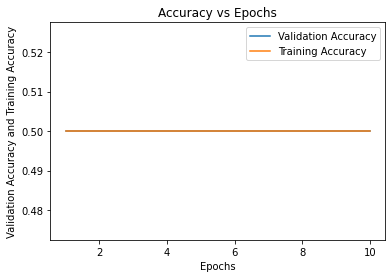

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

## 1e-5

In [ ]:
# EPOCHS = 5
model = BertClassifier()
LR = 1e-5
optimizer = Adam(model.parameters(), lr= LR)
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsaccredo/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelaccredo/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

100%|██████████| 8750/8750 [56:21<00:00,  2.59it/s]


Epochs: 1 | Train Loss:  0.102                 | Train Accuracy:  0.795                 | Val Loss:  0.067                 | Val Accuracy:  0.890
Validation Accuracy increased (-inf --> 0.889800).  Saving model ...


100%|██████████| 8750/8750 [56:25<00:00,  2.58it/s]


Epochs: 2 | Train Loss:  0.049                 | Train Accuracy:  0.930                 | Val Loss:  0.065                 | Val Accuracy:  0.908
Validation Accuracy increased (0.889800 --> 0.908000).  Saving model ...


 37%|███▋      | 3212/8750 [20:43<35:42,  2.58it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_rela

range(3, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [56:23<00:00,  2.59it/s]


Epochs: 3 | Train Loss:  0.020                 | Train Accuracy:  0.976                 | Val Loss:  0.094                 | Val Accuracy:  0.903


100%|██████████| 8750/8750 [56:32<00:00,  2.58it/s]


Epochs: 4 | Train Loss:  0.009                 | Train Accuracy:  0.990                 | Val Loss:  0.098                 | Val Accuracy:  0.908
Validation Accuracy increased (0.908000 --> 0.908000).  Saving model ...


100%|██████████| 8750/8750 [56:25<00:00,  2.58it/s]


Epochs: 5 | Train Loss:  0.007                 | Train Accuracy:  0.992                 | Val Loss:  0.121                 | Val Accuracy:  0.902


 67%|██████▋   | 5836/8750 [37:37<18:39,  2.60it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transf

range(6, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [55:14<00:00,  2.64it/s]


Epochs: 6 | Train Loss:  0.005                 | Train Accuracy:  0.994                 | Val Loss:  0.106                 | Val Accuracy:  0.906


100%|██████████| 8750/8750 [55:14<00:00,  2.64it/s]


Epochs: 7 | Train Loss:  0.004                 | Train Accuracy:  0.995                 | Val Loss:  0.188                 | Val Accuracy:  0.888


 62%|██████▏   | 5444/8750 [34:20<20:52,  2.64it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.

range(8, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [54:02<00:00,  2.70it/s]


Epochs: 8 | Train Loss:  0.004                 | Train Accuracy:  0.995                 | Val Loss:  0.098                 | Val Accuracy:  0.898


100%|██████████| 8750/8750 [53:57<00:00,  2.70it/s]


Epochs: 9 | Train Loss:  0.003                 | Train Accuracy:  0.996                 | Val Loss:  0.168                 | Val Accuracy:  0.906


100%|██████████| 8750/8750 [54:01<00:00,  2.70it/s]


Epochs: 10 | Train Loss:  0.004                 | Train Accuracy:  0.996                 | Val Loss:  0.135                 | Val Accuracy:  0.904


In [ ]:
val_acc=[0.889800,0.908000,0.903,0.908000,0.902,0.906,0.888,0.898,0.906,0.904]
train_acc=[0.795,0.930,0.976,0.990,0.992,0.994,0.995,0.995,0.996,0.996]

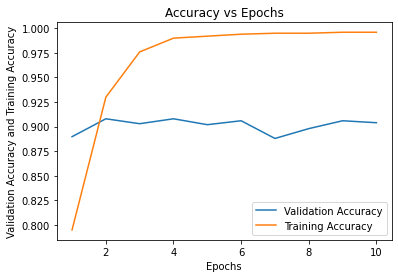

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

## 5e-5

In [ ]:
LR = 5e-5
epochs = [1,2,3,4,5,6,7,8,9,10]
test_acc =[]
val_acc=[]

checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacclr5e-5/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacclr5e-5/model.pt'

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8750/8750 [53:33<00:00,  2.72it/s]


Epochs: 1 | Train Loss:  0.173                 | Train Accuracy:  0.499                 | Val Loss:  0.173                 | Val Accuracy:  0.501
Validation Accuracy increased (-inf --> 0.501400).  Saving model ...


100%|██████████| 8750/8750 [52:44<00:00,  2.77it/s]


Epochs: 2 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [52:40<00:00,  2.77it/s]


Epochs: 3 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


 99%|█████████▉| 8705/8750 [52:22<00:16,  2.77it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.

range(4, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [53:03<00:00,  2.75it/s]


Epochs: 4 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


 17%|█▋        | 1447/8750 [08:46<44:12,  2.75it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerN

range(5, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [51:31<00:00,  2.83it/s]


Epochs: 5 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [51:31<00:00,  2.83it/s]


Epochs: 6 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [51:35<00:00,  2.83it/s]


Epochs: 7 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [51:32<00:00,  2.83it/s]


Epochs: 8 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


 76%|███████▋  | 6683/8750 [39:18<12:10,  2.83it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.

range(9, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [52:09<00:00,  2.80it/s]


Epochs: 9 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [52:07<00:00,  2.80it/s]


Epochs: 10 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


In [ ]:
val_acc=[0.501400,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500]
train_acc=[0.499,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500]

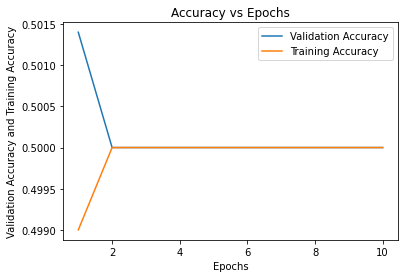

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

## 5e-6

In [ ]:
LR = 5e-6
epochs = [1,2,3,4,5,6,7,8,9,10]
test_acc =[]
val_acc=[]

checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacclr5e-6/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacclr5e-6/model.pt'

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8750/8750 [53:36<00:00,  2.72it/s]


Epochs: 1 | Train Loss:  0.150                 | Train Accuracy:  0.627                 | Val Loss:  0.085                 | Val Accuracy:  0.868
Validation Accuracy increased (-inf --> 0.867800).  Saving model ...


100%|██████████| 8750/8750 [54:05<00:00,  2.70it/s]


Epochs: 2 | Train Loss:  0.067                 | Train Accuracy:  0.901                 | Val Loss:  0.061                 | Val Accuracy:  0.907
Validation Accuracy increased (0.867800 --> 0.907200).  Saving model ...


 53%|█████▎    | 4650/8750 [28:44<25:18,  2.70it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.prediction

range(3, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [55:44<00:00,  2.62it/s]


Epochs: 3 | Train Loss:  0.033                 | Train Accuracy:  0.957                 | Val Loss:  0.092                 | Val Accuracy:  0.893


 87%|████████▋ | 7607/8750 [48:27<07:22,  2.58it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transf

range(4, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [56:56<00:00,  2.56it/s]


Epochs: 4 | Train Loss:  0.013                 | Train Accuracy:  0.987                 | Val Loss:  0.089                 | Val Accuracy:  0.904


100%|██████████| 8750/8750 [57:02<00:00,  2.56it/s]


Epochs: 5 | Train Loss:  0.008                 | Train Accuracy:  0.993                 | Val Loss:  0.117                 | Val Accuracy:  0.898


100%|██████████| 8750/8750 [57:00<00:00,  2.56it/s]


Epochs: 6 | Train Loss:  0.006                 | Train Accuracy:  0.994                 | Val Loss:  0.101                 | Val Accuracy:  0.908
Validation Accuracy increased (0.907200 --> 0.908200).  Saving model ...


100%|██████████| 8750/8750 [56:59<00:00,  2.56it/s]


Epochs: 7 | Train Loss:  0.004                 | Train Accuracy:  0.996                 | Val Loss:  0.135                 | Val Accuracy:  0.907


 26%|██▌       | 2289/8750 [14:54<42:13,  2.55it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predic

range(8, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [53:39<00:00,  2.72it/s]


Epochs: 8 | Train Loss:  0.004                 | Train Accuracy:  0.996                 | Val Loss:  0.137                 | Val Accuracy:  0.901


100%|██████████| 8750/8750 [53:36<00:00,  2.72it/s]


Epochs: 9 | Train Loss:  0.003                 | Train Accuracy:  0.997                 | Val Loss:  0.155                 | Val Accuracy:  0.904


100%|██████████| 8750/8750 [53:29<00:00,  2.73it/s]


Epochs: 10 | Train Loss:  0.002                 | Train Accuracy:  0.997                 | Val Loss:  0.196                 | Val Accuracy:  0.904


In [ ]:
val_acc=[0.868,0.907,0.893,0.904,0.898,0.908,0.907,0.901,0.904,0.904]
train_acc=[0.627,0.901,0.957,0.987,0.993,0.994,0.996,0.996,0.997,0.997]

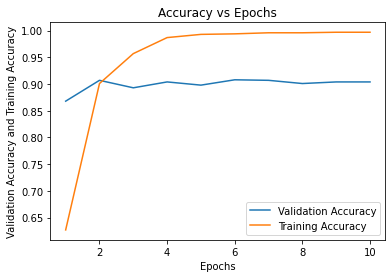

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

##1e-6

In [ ]:
LR = 1e-6
EPOCHS = [1,2,3,4,5,6,7,8,9,10]
test_acc =[]
val_acc=[]

checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacclr1e-6/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacclr1e-6/model.pt'

In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model,-np.inf)

100%|██████████| 8750/8750 [56:49<00:00,  2.57it/s]
Epochs: 1 | Train Loss:  0.106                 | Train Accuracy:  0.787                 | Val Loss:  0.197                 | Val Accuracy:  0.909
Validation Accuracy increased (-inf --> 0.908800).  Saving model ...
100%|██████████| 8750/8750 [58:23<00:00,  2.50it/s]
Epochs: 2 | Train Loss:  0.052                 | Train Accuracy:  0.925                 | Val Loss:  0.254                 | Val Accuracy:  0.909
Validation Accuracy increased (0.908800 --> 0.909400).  Saving model ...
100%|██████████| 8750/8750 [58:05<00:00,  2.51it/s]
Epochs: 3 | Train Loss:  0.022                 | Train Accuracy:  0.972                 | Val Loss:  0.282                 | Val Accuracy:  0.910
Validation Accuracy increased (0.909400 --> 0.909600).  Saving model ...
100%|██████████| 8750/8750 [57:41<00:00,  2.53it/s]
Epochs: 4 | Train Loss:  0.007                 | Train Accuracy:  0.993                 | Val Loss:  0.331                 | Val Accuracy: 

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls

range(6, 10)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [54:03<00:00,  2.70it/s]
Epochs: 6 | Train Loss:  0.005                 | Train Accuracy:  0.994                 | Val Loss:  0.559                 | Val Accuracy:  0.911
Validation Accuracy increased (0.909600 --> 0.911400).  Saving model ...
100%|██████████| 8750/8750 [54:11<00:00,  2.69it/s]
Epochs: 7 | Train Loss:  0.004                 | Train Accuracy:  0.995                 | Val Loss:  0.578                 | Val Accuracy:  0.911
100%|██████████| 8750/8750 [54:12<00:00,  2.69it/s]
Epochs: 8 | Train Loss:  0.004                 | Train Accuracy:  0.995                 | Val Loss:  0.604                 | Val Accuracy:  0.911
 19%|█▉        | 1678/8750 [10:24<43:45,  2.69it/s]


In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transf

range(9, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model,valid_accuracy_max)

100%|██████████| 8750/8750 [53:22<00:00,  2.73it/s]


Epochs: 9 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.620                 | Val Accuracy:  0.911


100%|██████████| 8750/8750 [53:29<00:00,  2.73it/s]


Epochs: 10 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.642                 | Val Accuracy:  0.908


In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,17)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transf

In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model,valid_accuracy_max)

100%|██████████| 8750/8750 [56:49<00:00,  2.57it/s]
Epochs: 11 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.197                 | Val Accuracy:  0.909
100%|██████████| 8750/8750 [58:23<00:00,  2.50it/s]
Epochs: 12 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.254                 | Val Accuracy:  0.909
100%|██████████| 8750/8750 [58:05<00:00,  2.51it/s]
Epochs: 13 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.282                 | Val Accuracy:  0.910
100%|██████████| 8750/8750 [57:41<00:00,  2.53it/s]
Epochs: 14 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.331                 | Val Accuracy:  0.908
100%|██████████| 8750/8750 [57:21<00:00,  2.54it/s]
Epochs: 15 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.409                 | Val Accuracy:  0.909
 17%|

In [ ]:
val_acc=[0.909,0.909,0.910,0.908,0.909,0.911,0.911,0.911,0.911,0.908,0.909,0.909,0.910,0.908,0.909]
train_acc=[0.787,0.925,0.972,0.993,0.994,0.994,0.995,0.995,1,1,1,1,1,1,1]

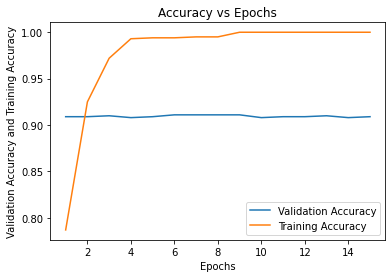

In [ ]:
plt.plot(range(1,16), val_acc, label='Validation Accuracy')
plt.plot(range(1,16), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

##5e-4

In [ ]:
LR = 5e-4
epochs = [1,2,3,4,5,6,7,8,9,10]
test_acc =[]
val_acc=[]

checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacclr5e-4/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacclr5e-4/model.pt'

In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model,-np.inf)

100%|██████████| 8750/8750 [51:38<00:00,  2.82it/s]
Epochs: 1 | Train Loss:  0.174                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (-inf --> 0.500000).  Saving model ...
100%|██████████| 8750/8750 [54:21<00:00,  2.68it/s]
Epochs: 2 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...
100%|██████████| 8750/8750 [54:17<00:00,  2.69it/s]
Epochs: 3 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...
40%|███▉      | 3482/8750 [20:31<30:59,  2.83it/s]


In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,10)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relation

range(4, 10)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model,valid_accuracy_max)

100%|██████████| 8750/8750 [53:27<00:00,  2.73it/s]


Epochs: 4 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [53:35<00:00,  2.72it/s]


Epochs: 5 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [53:31<00:00,  2.72it/s]


Epochs: 6 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [53:31<00:00,  2.72it/s]


Epochs: 7 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


 34%|███▍      | 2989/8750 [18:12<35:11,  2.73it/s]

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predic

range(8, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model,valid_accuracy_max)

100%|██████████| 8750/8750 [53:27<00:00,  2.73it/s]
Epochs: 8 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
100%|██████████| 8750/8750 [53:35<00:00,  2.72it/s]
Epochs: 9 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
100%|██████████| 8750/8750 [53:31<00:00,  2.72it/s]
Epochs: 10 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


In [ ]:
val_acc=[0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500]
train_acc=[0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500]

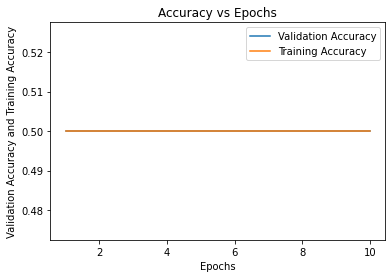

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

##1e-4


In [ ]:
LR = 1e-4
epochs = [1,2,3,4,5,6,7,8,9,10]
test_acc =[]
val_acc=[]

checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacc1e-4/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacc1e-4/model.pt'

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8750/8750 [53:32<00:00,  2.72it/s]


Epochs: 1 | Train Loss:  0.174                 | Train Accuracy:  0.501                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (-inf --> 0.499800).  Saving model ...


100%|██████████| 8750/8750 [53:23<00:00,  2.73it/s]


Epochs: 2 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.499800 --> 0.500200).  Saving model ...


100%|██████████| 8750/8750 [53:21<00:00,  2.73it/s]


Epochs: 3 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [53:22<00:00,  2.73it/s]


Epochs: 4 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


 28%|██▊       | 2444/8750 [14:54<38:27,  2.73it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.d

range(5, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [55:57<00:00,  2.61it/s]


Epochs: 5 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [56:07<00:00,  2.60it/s]


Epochs: 6 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [56:04<00:00,  2.60it/s]


Epochs: 7 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


 79%|███████▉  | 6937/8750 [44:26<11:35,  2.61it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predicti

range(8, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [54:24<00:00,  2.68it/s]


Epochs: 8 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [54:23<00:00,  2.68it/s]


Epochs: 9 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [54:24<00:00,  2.68it/s]


Epochs: 10 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


In [ ]:
train_acc=[0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500]
val_acc=[0.500,0.500,0.50,0.500,0.500,0.500,0.500,0.500,0.500,0.500]

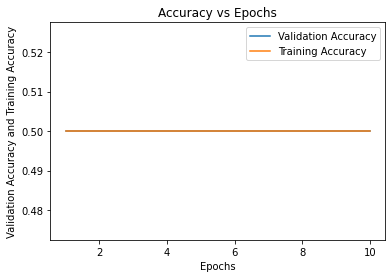

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

# Best from all lr

In [ ]:
# for 5e-6
val_acc_5e6=[0.868,0.907,0.893,0.904,0.898,0.908,0.907,0.901,0.904,0.904]
# for 1e-5
val_acc_1e5=[0.889800,0.908000,0.903,0.908000,0.902,0.906,0.888,0.898,0.906,0.904]
# for 5e-5
val_acc_5e5=[0.501400,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500]
# for 1e-6
val_acc_1e6=[0.909,0.909,0.910,0.908,0.909,0.911,0.911,0.911,0.911,0.908,0.909,0.909,0.910,0.908]
# for 5e-4
val_acc_5e4=[0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500]
# for 1e-4
val_acc_1e4=[0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500]

#get max validation accuracy for each learning rate
max_val_acc=[max(val_acc_5e6),max(val_acc_1e5),max(val_acc_5e5),max(val_acc_1e6),max(val_acc_5e4),max(val_acc_1e4)]

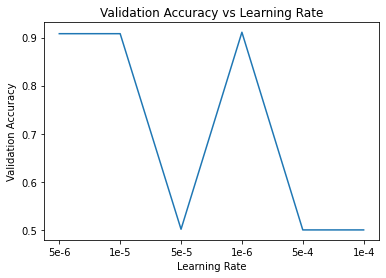

In [ ]:
# plot max validation accuracy for each learning rate
lr=['5e-6','1e-5','5e-5','1e-6','5e-4','1e-4']
plt.plot(lr, max_val_acc, label='Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate')
plt.show()

# Bonus

## 768,64,128,256,128,64,2

In [ ]:
from torch.nn.modules import linear
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout_1 = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(768,64)
        self.dropout_2 = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(64, 128)
        self.dropout_3 = nn.Dropout(dropout)
        self.linear_3 = nn.Linear(128, 256)
        self.dropout_4 = nn.Dropout(dropout)
        self.linear_4= nn.Linear(256, 128)
        self.dropout_5 = nn.Dropout(dropout)
        self.linear_5= nn.Linear(128, 64)
        self.dropout_6 = nn.Dropout(dropout)
        self.linear_6= nn.Linear(64, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout_1(pooled_output)
        linear_output_1 = self.linear_1(dropout_output)
        dropout_output_1 = self.dropout_2(linear_output_1)
        linear_output_2 = self.linear_2(dropout_output_1)
        dropout_output_2 = self.dropout_3(linear_output_2)
        linear_output_3 = self.linear_3(dropout_output_2)
        dropout_output_3 = self.dropout_4(linear_output_3)
        linear_output_4 = self.linear_4(dropout_output_3)
        dropout_output_4 = self.dropout_5(linear_output_4)
        linear_output_5 = self.linear_5(dropout_output_4)
        dropout_output_5 = self.dropout_6(linear_output_5)
        linear_output_6 = self.linear_6(dropout_output_5)
        final_layer = self.relu(linear_output_6)
        return final_layer

### 1e-6

In [ ]:
model = BertClassifier()
LR = 1e-6
optimizer = Adam(model.parameters(), lr= LR)
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsaccbonus/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelaccbonus/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

100%|██████████| 8750/8750 [53:58<00:00,  2.70it/s]


Epochs: 1 | Train Loss:  0.121                 | Train Accuracy:  0.832                 | Val Loss:  0.093                 | Val Accuracy:  0.867
Validation Accuracy increased (-inf --> 0.867000).  Saving model ...


100%|██████████| 8750/8750 [54:03<00:00,  2.70it/s]


Epochs: 2 | Train Loss:  0.077                 | Train Accuracy:  0.895                 | Val Loss:  0.078                 | Val Accuracy:  0.881
Validation Accuracy increased (0.867000 --> 0.880800).  Saving model ...


 61%|██████    | 5339/8750 [32:59<21:10,  2.69it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.wei

range(3, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [56:57<00:00,  2.56it/s]


Epochs: 3 | Train Loss:  0.060                 | Train Accuracy:  0.922                 | Val Loss:  0.075                 | Val Accuracy:  0.880


  6%|▋         | 557/8750 [03:37<52:59,  2.58it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predic

range(4, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [57:49<00:00,  2.52it/s]


Epochs: 4 | Train Loss:  0.045                 | Train Accuracy:  0.946                 | Val Loss:  0.076                 | Val Accuracy:  0.893
Validation Accuracy increased (0.880800 --> 0.893200).  Saving model ...


100%|██████████| 8750/8750 [57:42<00:00,  2.53it/s]


Epochs: 5 | Train Loss:  0.032                 | Train Accuracy:  0.968                 | Val Loss:  0.083                 | Val Accuracy:  0.893


100%|██████████| 8750/8750 [57:43<00:00,  2.53it/s]


Epochs: 6 | Train Loss:  0.022                 | Train Accuracy:  0.981                 | Val Loss:  0.104                 | Val Accuracy:  0.896
Validation Accuracy increased (0.893200 --> 0.896000).  Saving model ...


 68%|██████▊   | 5926/8750 [39:06<18:34,  2.53it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight

range(7, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [54:31<00:00,  2.67it/s]


Epochs: 7 | Train Loss:  0.015                 | Train Accuracy:  0.989                 | Val Loss:  0.119                 | Val Accuracy:  0.895


100%|██████████| 8750/8750 [54:31<00:00,  2.67it/s]


Epochs: 8 | Train Loss:  0.011                 | Train Accuracy:  0.993                 | Val Loss:  0.140                 | Val Accuracy:  0.894


 45%|████▍     | 3919/8750 [24:23<30:05,  2.68it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.prediction

range(9, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [56:10<00:00,  2.60it/s]


Epochs: 9 | Train Loss:  0.008                 | Train Accuracy:  0.994                 | Val Loss:  0.156                 | Val Accuracy:  0.894


100%|██████████| 8750/8750 [56:06<00:00,  2.60it/s]


Epochs: 10 | Train Loss:  0.006                 | Train Accuracy:  0.996                 | Val Loss:  0.185                 | Val Accuracy:  0.895


In [ ]:
val_acc=[0.867000,0.880800,0.880,0.893200,0.893,0.896000,0.895,0.894,0.894, 0.8946] 
train_acc=[0.832, 0.895,0.922,0.946, 0.968,0.981,0.989,0.993,0.944,0.996]

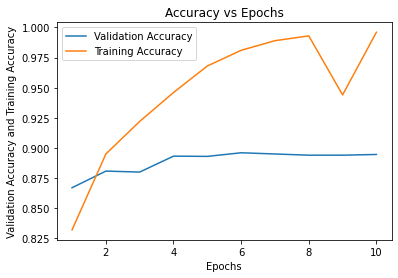

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

### 5e-6

In [ ]:
model = BertClassifier()
LR = 5e-6
optimizer = Adam(model.parameters(), lr= LR)
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsaccbonus/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelaccbonus/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

100%|██████████| 8750/8750 [53:23<00:00,  2.73it/s]


Epochs: 1 | Train Loss:  0.065                 | Train Accuracy:  0.907                 | Val Loss:  0.065                 | Val Accuracy:  0.901
Validation Accuracy increased (-inf --> 0.901200).  Saving model ...


100%|██████████| 8750/8750 [53:23<00:00,  2.73it/s]


Epochs: 2 | Train Loss:  0.035                 | Train Accuracy:  0.958                 | Val Loss:  0.078                 | Val Accuracy:  0.901
Validation Accuracy increased (0.901200 --> 0.901200).  Saving model ...


100%|██████████| 8750/8750 [53:22<00:00,  2.73it/s]


Epochs: 3 | Train Loss:  0.014                 | Train Accuracy:  0.985                 | Val Loss:  0.104                 | Val Accuracy:  0.889


 38%|███▊      | 3306/8750 [20:08<33:09,  2.74it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform

range(4, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [57:39<00:00,  2.53it/s]


Epochs: 4 | Train Loss:  0.008                 | Train Accuracy:  0.992                 | Val Loss:  0.172                 | Val Accuracy:  0.873


100%|██████████| 8750/8750 [57:35<00:00,  2.53it/s]


Epochs: 5 | Train Loss:  0.006                 | Train Accuracy:  0.995                 | Val Loss:  0.148                 | Val Accuracy:  0.904
Validation Accuracy increased (0.901200 --> 0.903600).  Saving model ...


100%|██████████| 8750/8750 [57:31<00:00,  2.54it/s]


Epochs: 6 | Train Loss:  0.005                 | Train Accuracy:  0.995                 | Val Loss:  0.139                 | Val Accuracy:  0.906
Validation Accuracy increased (0.903600 --> 0.905600).  Saving model ...


 72%|███████▏  | 6285/8750 [41:13<16:14,  2.53it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls

range(7, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [58:09<00:00,  2.51it/s]


Epochs: 7 | Train Loss:  0.004                 | Train Accuracy:  0.995                 | Val Loss:  0.178                 | Val Accuracy:  0.905


100%|██████████| 8750/8750 [57:58<00:00,  2.52it/s]


Epochs: 8 | Train Loss:  0.003                 | Train Accuracy:  0.997                 | Val Loss:  0.190                 | Val Accuracy:  0.906
Validation Accuracy increased (0.905600 --> 0.906400).  Saving model ...


 36%|███▌      | 3159/8750 [20:54<37:07,  2.51it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform

range(9, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [55:42<00:00,  2.62it/s]


Epochs: 9 | Train Loss:  0.003                 | Train Accuracy:  0.997                 | Val Loss:  0.195                 | Val Accuracy:  0.899


100%|██████████| 8750/8750 [55:36<00:00,  2.62it/s]


Epochs: 10 | Train Loss:  0.003                 | Train Accuracy:  0.997                 | Val Loss:  0.187                 | Val Accuracy:  0.904


In [ ]:
val_acc=[0.901200,0.901200,0.889,0.873,0.903600,0.905600,0.905,0.906400,0.899, 0.9044] 
train_acc=[0.907,0.958,0.985,0.992,0.995,0.995,0.995,0.997,0.997,0.997]

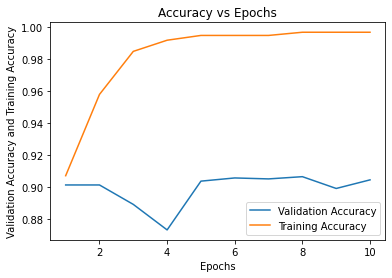

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

### 1e-5

In [ ]:
model = BertClassifier()
LR = 1e-5
optimizer = Adam(model.parameters(), lr= LR)
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsaccbonus/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelaccbonus/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

100%|██████████| 8750/8750 [56:12<00:00,  2.59it/s]


Epochs: 1 | Train Loss:  0.174                 | Train Accuracy:  0.502                 | Val Loss:  0.174                 | Val Accuracy:  0.498
Validation Accuracy increased (-inf --> 0.498400).  Saving model ...


100%|██████████| 8750/8750 [55:13<00:00,  2.64it/s]


Epochs: 2 | Train Loss:  0.174                 | Train Accuracy:  0.498                 | Val Loss:  0.173                 | Val Accuracy:  0.503
Validation Accuracy increased (0.498400 --> 0.502600).  Saving model ...


100%|██████████| 8750/8750 [55:09<00:00,  2.64it/s]


Epochs: 3 | Train Loss:  0.174                 | Train Accuracy:  0.501                 | Val Loss:  0.173                 | Val Accuracy:  0.499


100%|██████████| 8750/8750 [56:18<00:00,  2.59it/s]


Epochs: 4 | Train Loss:  0.134                 | Train Accuracy:  0.699                 | Val Loss:  0.082                 | Val Accuracy:  0.868
Validation Accuracy increased (0.502600 --> 0.868200).  Saving model ...


100%|██████████| 8750/8750 [56:46<00:00,  2.57it/s]


Epochs: 5 | Train Loss:  0.071                 | Train Accuracy:  0.892                 | Val Loss:  0.066                 | Val Accuracy:  0.899
Validation Accuracy increased (0.868200 --> 0.898600).  Saving model ...


100%|██████████| 8750/8750 [56:47<00:00,  2.57it/s]


Epochs: 6 | Train Loss:  0.046                 | Train Accuracy:  0.938                 | Val Loss:  0.068                 | Val Accuracy:  0.904
Validation Accuracy increased (0.898600 --> 0.903600).  Saving model ...


 23%|██▎       | 1979/8750 [12:51<43:40,  2.58it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.

range(7, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [54:56<00:00,  2.65it/s]


Epochs: 7 | Train Loss:  0.025                 | Train Accuracy:  0.970                 | Val Loss:  0.087                 | Val Accuracy:  0.903


100%|██████████| 8750/8750 [54:52<00:00,  2.66it/s]


Epochs: 8 | Train Loss:  0.015                 | Train Accuracy:  0.985                 | Val Loss:  0.105                 | Val Accuracy:  0.906
Validation Accuracy increased (0.903600 --> 0.905800).  Saving model ...


100%|██████████| 8750/8750 [54:48<00:00,  2.66it/s]


Epochs: 9 | Train Loss:  0.010                 | Train Accuracy:  0.991                 | Val Loss:  0.129                 | Val Accuracy:  0.905


 67%|██████▋   | 5906/8750 [36:57<17:47,  2.66it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls

range(10, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [53:50<00:00,  2.71it/s]


Epochs: 10 | Train Loss:  0.009                 | Train Accuracy:  0.992                 | Val Loss:  0.122                 | Val Accuracy:  0.900


In [ ]:
val_acc=[0.498,0.502600 ,0.499,0.868200,0.898600,0.903600,0.903,0.905800,0.905,0.900]
train_acc=[0.502,0.498,0.501,0.699,0.892,0.938,0.970,0.985,0.991,0.992]

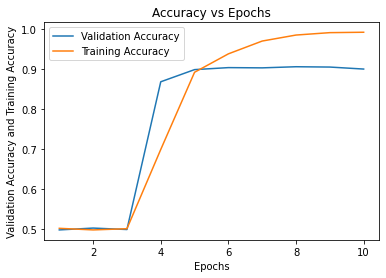

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

### Best from all lr

In [ ]:
# for 5e-6
val_acc_5e6=[0.901200,0.901200,0.889,0.873,0.903600,0.905600,0.905,0.906400,0.899, 0.9044] 
# for 1e-5
val_acc_1e5=[0.498,0.502600 ,0.499,0.868200,0.898600,0.903600,0.903,0.905800,0.905,0.900]
# for 1e-6
val_acc_1e6=[0.867000,0.880800,0.880,0.893200,0.893,0.896000,0.895,0.894,0.894, 0.8946] 


#get max validation accuracy for each learning rate
max_val_acc=[max(val_acc_5e6),max(val_acc_1e5),max(val_acc_1e6)]

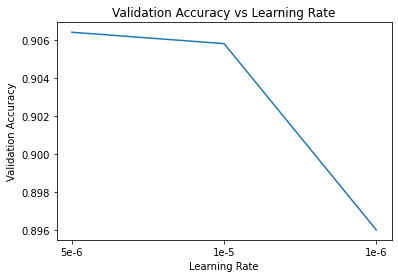

In [ ]:
# plot max validation accuracy for each learning rate
lr=['5e-6','1e-5','1e-6']
plt.plot(lr, max_val_acc, label='Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate')
plt.show()

### Best Model

In [ ]:
def conf_mat(test_labels,pred_labels):
      conf_matrix = confusion_matrix(test_labels, pred_labels)
      fig, ax = plt.subplots(figsize=(5, 5))
      ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
      for i in range(conf_matrix.shape[0]):
          for j in range(conf_matrix.shape[1]):
              ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

      plt.xlabel('Predictions', fontsize=18)
      plt.ylabel('Actuals', fontsize=18)
      plt.title('Confusion Matrix', fontsize=18)
      plt.show()

In [ ]:
test_labels=[]
pred_labels=[]

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

              test_labels.append(test_label.cpu().numpy()[0])
              test_labels.append(test_label.cpu().numpy()[1])
              pred_labels.append(output.argmax(dim=1).cpu().numpy()[0])
              pred_labels.append(output.argmax(dim=1).cpu().numpy()[1])


In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
best_epoch=0
valid_accuracy_max=0
LR = 5e-6
optimizer = Adam(model.parameters(), lr= LR)
best_model = '/content/drive/MyDrive/bert/bestmodelaccbonus/model.pt'
model, optimizer, best_epoch,valid_accuracy_max, LR= load_model_accuracy(best_model, model, optimizer)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
LR

5e-06

In [ ]:
best_epoch

8

In [ ]:
valid_accuracy_max

0.9064

In [ ]:
evaluate(model, test_data)

Test Accuracy:  0.901


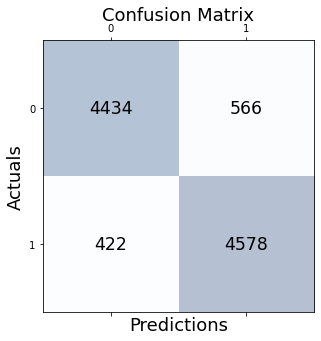

In [ ]:
conf_mat(test_labels,pred_labels)

In [ ]:
def evalscore(tp,tn,fp,fn):
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  specificity=tn/(tn+fp)
  f1=(2*precision*recall)/(precision+recall)

  print(f'F1-score:    {f1:.3f}')
  print(f'Precision:   {precision:.3f}')
  print(f'Recall:      {recall:.3f}')
  print(f'Specificity: {specificity:.3f}')

In [ ]:
tp=4434
tn=4578
fp=422
fn=566

evalscore(tp,tn,fp,fn)

F1-score:    0.900
Precision:   0.913
Recall:      0.887
Specificity: 0.916


## 768,1024,256,16,4,2

In [ ]:
from torch.nn.modules import linear
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout_1 = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(768,1024)
        self.dropout_2 = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(1024, 256)
        self.dropout_3 = nn.Dropout(dropout)
        self.linear_3 = nn.Linear(256, 16)
        self.dropout_4 = nn.Dropout(dropout)
        self.linear_4= nn.Linear(16, 4)
        self.dropout_5 = nn.Dropout(dropout)
        self.linear_5= nn.Linear(4, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout_1(pooled_output)
        linear_output_1 = self.linear_1(dropout_output)
        dropout_output_1 = self.dropout_2(linear_output_1)
        linear_output_2 = self.linear_2(dropout_output_1)
        dropout_output_2 = self.dropout_3(linear_output_2)
        linear_output_3 = self.linear_3(dropout_output_2)
        dropout_output_3 = self.dropout_4(linear_output_3)
        linear_output_4 = self.linear_4(dropout_output_3)
        dropout_output_4 = self.dropout_5(linear_output_4)
        linear_output_5 = self.linear_5(dropout_output_4)
        final_layer = self.relu(linear_output_5)
        return final_layer

### 1e-6

In [ ]:
model = BertClassifier()
LR = 1e-6
optimizer = Adam(model.parameters(), lr= LR)
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsaccbonus2/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelaccbonus2/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

100%|██████████| 8750/8750 [54:13<00:00,  2.69it/s]


Epochs: 1 | Train Loss:  0.158                 | Train Accuracy:  0.504                 | Val Loss:  0.141                 | Val Accuracy:  0.522
Validation Accuracy increased (-inf --> 0.522400).  Saving model ...


100%|██████████| 8750/8750 [54:17<00:00,  2.69it/s]


Epochs: 2 | Train Loss:  0.134                 | Train Accuracy:  0.584                 | Val Loss:  0.125                 | Val Accuracy:  0.648
Validation Accuracy increased (0.522400 --> 0.648200).  Saving model ...


 25%|██▌       | 2201/8750 [13:43<40:49,  2.67it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relation

range(3, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [56:19<00:00,  2.59it/s]


Epochs: 3 | Train Loss:  0.120                 | Train Accuracy:  0.665                 | Val Loss:  0.119                 | Val Accuracy:  0.671
Validation Accuracy increased (0.648200 --> 0.671400).  Saving model ...


100%|██████████| 8750/8750 [56:21<00:00,  2.59it/s]


Epochs: 4 | Train Loss:  0.109                 | Train Accuracy:  0.700                 | Val Loss:  0.117                 | Val Accuracy:  0.683
Validation Accuracy increased (0.671400 --> 0.682800).  Saving model ...


100%|██████████| 8750/8750 [56:21<00:00,  2.59it/s]


Epochs: 5 | Train Loss:  0.102                 | Train Accuracy:  0.720                 | Val Loss:  0.114                 | Val Accuracy:  0.704
Validation Accuracy increased (0.682800 --> 0.704400).  Saving model ...


 70%|███████   | 6136/8750 [39:32<16:46,  2.60it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relati

range(6, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [56:22<00:00,  2.59it/s]


Epochs: 6 | Train Loss:  0.095                 | Train Accuracy:  0.744                 | Val Loss:  0.114                 | Val Accuracy:  0.725
Validation Accuracy increased (0.704400 --> 0.725400).  Saving model ...


100%|██████████| 8750/8750 [56:20<00:00,  2.59it/s]


Epochs: 7 | Train Loss:  0.086                 | Train Accuracy:  0.784                 | Val Loss:  0.127                 | Val Accuracy:  0.744
Validation Accuracy increased (0.725400 --> 0.744200).  Saving model ...


 47%|████▋     | 4144/8750 [26:42<29:53,  2.57it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predic

range(8, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [57:11<00:00,  2.55it/s]


Epochs: 8 | Train Loss:  0.081                 | Train Accuracy:  0.806                 | Val Loss:  0.117                 | Val Accuracy:  0.764
Validation Accuracy increased (0.744200 --> 0.764000).  Saving model ...


100%|██████████| 8750/8750 [57:09<00:00,  2.55it/s]


Epochs: 9 | Train Loss:  0.073                 | Train Accuracy:  0.827                 | Val Loss:  0.127                 | Val Accuracy:  0.758


100%|██████████| 8750/8750 [57:11<00:00,  2.55it/s]


Epochs: 10 | Train Loss:  0.070                 | Train Accuracy:  0.834                 | Val Loss:  0.136                 | Val Accuracy:  0.769
Validation Accuracy increased (0.764000 --> 0.769000).  Saving model ...


In [ ]:
val_acc=[0.522400,0.648200,0.671400,0.682800,0.704400,0.725400,0.744200,0.764000,0.758,0.769000]
train_acc=[0.504,0.584,0.665,0.700,0.720,0.744,0.784,0.806,0.827,0.834]

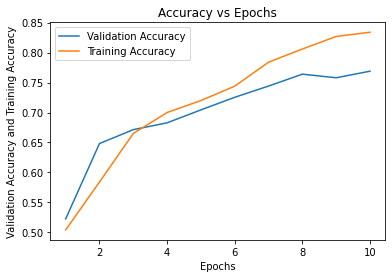

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

### 5e-6

In [ ]:
model = BertClassifier()
LR = 5e-6
optimizer = Adam(model.parameters(), lr= LR)
checkpoint_path = '/content/drive/MyDrive/bonusnadasedition/checkpoints/check.pt'
best_model = '/content/drive/MyDrive/bonusnadasedition/bestmodel/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

100%|██████████| 8750/8750 [53:07<00:00,  2.75it/s]


Epochs: 1 | Train Loss:  0.158                 | Train Accuracy:  0.594                 | Val Loss:  0.127                 | Val Accuracy:  0.743
Validation Accuracy increased (-inf --> 0.742600).  Saving model ...


100%|██████████| 8750/8750 [53:40<00:00,  2.72it/s]


Epochs: 2 | Train Loss:  0.119                 | Train Accuracy:  0.771                 | Val Loss:  0.112                 | Val Accuracy:  0.799
Validation Accuracy increased (0.742600 --> 0.798800).  Saving model ...


100%|██████████| 8750/8750 [53:44<00:00,  2.71it/s]


Epochs: 3 | Train Loss:  0.104                 | Train Accuracy:  0.809                 | Val Loss:  0.108                 | Val Accuracy:  0.802
Validation Accuracy increased (0.798800 --> 0.801800).  Saving model ...


100%|██████████| 8750/8750 [53:44<00:00,  2.71it/s]


Epochs: 4 | Train Loss:  0.091                 | Train Accuracy:  0.838                 | Val Loss:  0.106                 | Val Accuracy:  0.820
Validation Accuracy increased (0.801800 --> 0.820400).  Saving model ...


 86%|████████▋ | 7553/8750 [46:21<07:18,  2.73it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.

range(6, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [58:21<00:00,  2.50it/s]


Epochs: 6 | Train Loss:  0.069                 | Train Accuracy:  0.878                 | Val Loss:  0.111                 | Val Accuracy:  0.833
Validation Accuracy increased (0.830000 --> 0.833200).  Saving model ...


100%|██████████| 8750/8750 [58:28<00:00,  2.49it/s]


Epochs: 7 | Train Loss:  0.062                 | Train Accuracy:  0.893                 | Val Loss:  0.113                 | Val Accuracy:  0.840
Validation Accuracy increased (0.833200 --> 0.839800).  Saving model ...


100%|██████████| 8750/8750 [58:21<00:00,  2.50it/s]


Epochs: 8 | Train Loss:  0.055                 | Train Accuracy:  0.906                 | Val Loss:  0.128                 | Val Accuracy:  0.840


100%|██████████| 8750/8750 [58:15<00:00,  2.50it/s]


Epochs: 9 | Train Loss:  0.051                 | Train Accuracy:  0.913                 | Val Loss:  0.161                 | Val Accuracy:  0.839


100%|██████████| 8750/8750 [58:11<00:00,  2.51it/s]


Epochs: 10 | Train Loss:  0.048                 | Train Accuracy:  0.915                 | Val Loss:  0.161                 | Val Accuracy:  0.840
Validation Accuracy increased (0.839800 --> 0.840000).  Saving model ...


In [ ]:
val_acc=[0.742600,0.798800,0.801800,0.820400,0.83,0.833200,0.839800,0.8396,0.839,0.840]
train_acc=[0.594,0.771,0.809,0.838,0.870,0.878,0.893,0.906,0.913,0.915]

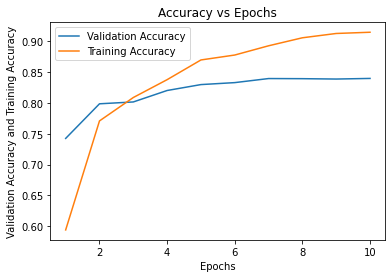

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

### 1e-5

In [ ]:
model = BertClassifier()
LR = 1e-5
optimizer = Adam(model.parameters(), lr= LR)
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsaccbonus2/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelaccbonus2/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

100%|██████████| 8750/8750 [54:55<00:00,  2.66it/s]


Epochs: 1 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (-inf --> 0.500000).  Saving model ...


100%|██████████| 8750/8750 [54:36<00:00,  2.67it/s]


Epochs: 2 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.174                 | Val Accuracy:  0.499


100%|██████████| 8750/8750 [54:32<00:00,  2.67it/s]


Epochs: 3 | Train Loss:  0.173                 | Train Accuracy:  0.499                 | Val Loss:  0.173                 | Val Accuracy:  0.501
Validation Accuracy increased (0.500000 --> 0.501000).  Saving model ...


 95%|█████████▍| 8288/8750 [51:38<02:52,  2.68it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerN

range(4, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [53:52<00:00,  2.71it/s]


Epochs: 4 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.501
Validation Accuracy increased (0.501000 --> 0.501200).  Saving model ...


100%|██████████| 8750/8750 [53:45<00:00,  2.71it/s]


Epochs: 5 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.501


 58%|█████▊    | 5106/8750 [31:22<22:24,  2.71it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relati

range(6, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [54:41<00:00,  2.67it/s]


Epochs: 6 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [54:38<00:00,  2.67it/s]


Epochs: 7 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [54:38<00:00,  2.67it/s]


Epochs: 8 | Train Loss:  0.173                 | Train Accuracy:  0.499                 | Val Loss:  0.173                 | Val Accuracy:  0.500


 82%|████████▏ | 7187/8750 [44:52<09:44,  2.67it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.b

range(9, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [56:06<00:00,  2.60it/s]


Epochs: 9 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.174                 | Val Accuracy:  0.498


100%|██████████| 8750/8750 [56:01<00:00,  2.60it/s]


Epochs: 10 | Train Loss:  0.173                 | Train Accuracy:  0.499                 | Val Loss:  0.173                 | Val Accuracy:  0.499


In [ ]:
val_acc=[0.500,0.499,0.501,0.501,0.501,0.500,0.500,0.500,0.4982, 0.499]
train_acc=[ 0.500, 0.500,0.499, 0.500, 0.500, 0.500, 0.500,0.499, 0.500,0.499]


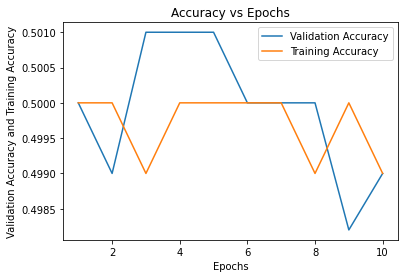

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

### Best from all lr

In [ ]:
# for 5e-6 to be added by mariem
val_acc_5e6=[0.742600,0.798800,0.801800,0.820400,0.83,0.833200,0.839800,0.8396,0.839,0.840] 
# for 1e-5
val_acc_1e5=[0.500,0.499,0.501,0.501,0.501,0.500,0.500,0.500,0.4982, 0.499]
# for 1e-6
val_acc_1e6=[0.522400,0.648200,0.671400,0.682800,0.704400,0.725400,0.744200,0.764000,0.758,0.769000] 


#get max validation accuracy for each learning rate
# max_val_acc=[max(val_acc_1e5),max(val_acc_1e6)]
max_val_acc=[max(val_acc_5e6),max(val_acc_1e5),max(val_acc_1e6)]

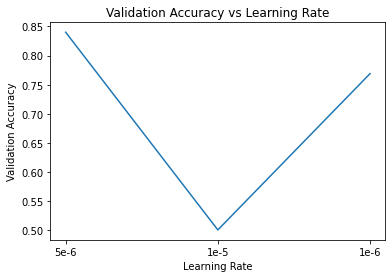

In [ ]:
# plot max validation accuracy for each learning rate
lr=['5e-6','1e-5','1e-6']
# lr=['1e-5','1e-6']
plt.plot(lr, max_val_acc, label='Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate')
plt.show()

### Best Model

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
LR = 5e-6
optimizer = Adam(model.parameters(), lr= LR)
best_model = '/content/drive/MyDrive/bonusnadasedition/bestmodelacc/model.pt'
model, optimizer, best_epoch,valid_accuracy_max, LR= load_model_accuracy(best_model, model, optimizer)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
LR

5e-06

In [ ]:
best_epoch

10

In [ ]:
valid_accuracy_max

0.84

In [ ]:
evaluate(model, test_data)

Test Accuracy:  0.840


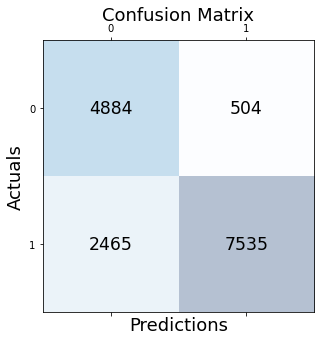

In [ ]:
conf_mat(test_labels,pred_labels)

In [ ]:
def evalscore(tp,tn,fp,fn):
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  specificity=tn/(tn+fp)
  f1=(2*precision*recall)/(precision+recall)

  print(f'F1-score:    {f1:.3f}')
  print(f'Precision:   {precision:.3f}')
  print(f'Recall:      {recall:.3f}')
  print(f'Specificity: {specificity:.3f}')

In [ ]:
tp=4884
tn=7535
fp=2465
fn=504

evalscore(tp,tn,fp,fn)

F1-score:    0.767
Precision:   0.665
Recall:      0.906
Specificity: 0.753


##768,32,128,512,128,32,2

In [ ]:
from torch.nn.modules import linear
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout_1 = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(768,32)
        self.dropout_2 = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(32, 128)
        self.dropout_3 = nn.Dropout(dropout)
        self.linear_3 = nn.Linear(128, 512)
        self.dropout_4 = nn.Dropout(dropout)
        self.linear_4= nn.Linear(512, 128)
        self.dropout_5 = nn.Dropout(dropout)
        self.linear_5= nn.Linear(128, 32)
        self.dropout_6 = nn.Dropout(dropout)
        self.linear_6= nn.Linear(32, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout_1(pooled_output)
        linear_output_1 = self.linear_1(dropout_output)
        dropout_output_1 = self.dropout_2(linear_output_1)
        linear_output_2 = self.linear_2(dropout_output_1)
        dropout_output_2 = self.dropout_3(linear_output_2)
        linear_output_3 = self.linear_3(dropout_output_2)
        dropout_output_3 = self.dropout_4(linear_output_3)
        linear_output_4 = self.linear_4(dropout_output_3)
        dropout_output_4 = self.dropout_5(linear_output_4)
        linear_output_5 = self.linear_5(dropout_output_4)
        dropout_output_5 = self.dropout_6(linear_output_5)
        linear_output_6 = self.linear_6(dropout_output_5)
        final_layer = self.relu(linear_output_6)

        return final_layer

###1e-5

In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model,-np.Inf)

100%|██████████| 8750/8750 [54:48<00:00,  2.66it/s]


Epochs: 1 | Train Loss:  0.174                 | Train Accuracy:  0.499                 | Val Loss:  0.173                 | Val Accuracy:  0.499
Validation Accuracy increased (-inf --> 0.498600).  Saving model ...


100%|██████████| 8750/8750 [54:05<00:00,  2.70it/s]


Epochs: 2 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.499
Validation Accuracy increased (0.498600 --> 0.498600).  Saving model ...


100%|██████████| 8750/8750 [53:52<00:00,  2.71it/s]


Epochs: 3 | Train Loss:  0.173                 | Train Accuracy:  0.502                 | Val Loss:  0.173                 | Val Accuracy:  0.502
Validation Accuracy increased (0.498600 --> 0.501800).  Saving model ...


100%|██████████| 8750/8750 [53:40<00:00,  2.72it/s]


Epochs: 4 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.174                 | Val Accuracy:  0.499


 57%|█████▋    | 5014/8750 [30:42<22:56,  2.71it/s]

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_ ,_ , _ , valid_accuracy_max, _ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, _ , LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
epochs = range(start_epoch+1, 11)
print(epochs)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.L

range(5, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model,valid_accuracy_max)

100%|██████████| 8750/8750 [54:19<00:00,  2.68it/s]


Epochs: 5 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.498


100%|██████████| 8750/8750 [54:25<00:00,  2.68it/s]


Epochs: 6 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.504
Validation Accuracy increased (0.501800 --> 0.504200).  Saving model ...


100%|██████████| 8750/8750 [54:24<00:00,  2.68it/s]


Epochs: 7 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [54:20<00:00,  2.68it/s]


Epochs: 8 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.501


100%|██████████| 8750/8750 [54:19<00:00,  2.68it/s]


Epochs: 9 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.499


 98%|█████████▊| 8563/8750 [53:09<01:09,  2.68it/s]

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_ ,_ , _ , valid_accuracy_max, _ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, _ , LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
epochs = range(start_epoch+1, 11)
print(epochs)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.L

In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model,valid_accuracy_max)

100%|██████████| 8750/8750 [54:24<00:00,  2.68it/s]
Epochs: 10 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


In [ ]:
val_acc=[0.499,0.499,0.502,0.499,0.498,0.504,0.500,0.501,0.499,0.500]
train_acc=[0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500]

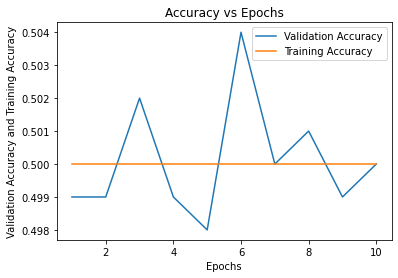

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

###1e-6

In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model,-np.Inf)

100%|██████████| 8750/8750 [56:38<00:00,  2.57it/s]


Epochs: 1 | Train Loss:  0.173                 | Train Accuracy:  0.526                 | Val Loss:  0.164                 | Val Accuracy:  0.661
Validation Accuracy increased (-inf --> 0.660800).  Saving model ...


100%|██████████| 8750/8750 [56:45<00:00,  2.57it/s]


Epochs: 2 | Train Loss:  0.124                 | Train Accuracy:  0.820                 | Val Loss:  0.094                 | Val Accuracy:  0.876
Validation Accuracy increased (0.660800 --> 0.875800).  Saving model ...


100%|██████████| 8750/8750 [56:48<00:00,  2.57it/s]


Epochs: 3 | Train Loss:  0.081                 | Train Accuracy:  0.895                 | Val Loss:  0.078                 | Val Accuracy:  0.890
Validation Accuracy increased (0.875800 --> 0.889600).  Saving model ...


 67%|██████▋   | 5863/8750 [38:02<18:38,  2.58it/s]

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_ ,_ , _ , valid_accuracy_max, _ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, _ , LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
epochs = range(start_epoch+1, 11)
print(epochs)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relati

range(4, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model,valid_accuracy_max)

100%|██████████| 8750/8750 [55:46<00:00,  2.61it/s]


Epochs: 4 | Train Loss:  0.062                 | Train Accuracy:  0.925                 | Val Loss:  0.075                 | Val Accuracy:  0.891
Validation Accuracy increased (0.889600 --> 0.890600).  Saving model ...


100%|██████████| 8750/8750 [55:47<00:00,  2.61it/s]


Epochs: 5 | Train Loss:  0.047                 | Train Accuracy:  0.949                 | Val Loss:  0.078                 | Val Accuracy:  0.895
Validation Accuracy increased (0.890600 --> 0.895400).  Saving model ...


 38%|███▊      | 3289/8750 [20:58<34:57,  2.60it/s]

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_ ,_ , _ , valid_accuracy_max, _ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, _ , LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
epochs = range(start_epoch+1, 11)
print(epochs)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.prediction

range(6, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model,valid_accuracy_max)

100%|██████████| 8750/8750 [57:47<00:00,  2.52it/s]


Epochs: 6 | Train Loss:  0.034                 | Train Accuracy:  0.968                 | Val Loss:  0.083                 | Val Accuracy:  0.895


100%|██████████| 8750/8750 [57:48<00:00,  2.52it/s]


Epochs: 7 | Train Loss:  0.024                 | Train Accuracy:  0.981                 | Val Loss:  0.107                 | Val Accuracy:  0.897
Validation Accuracy increased (0.895400 --> 0.896600).  Saving model ...


100%|██████████| 8750/8750 [57:48<00:00,  2.52it/s]


Epochs: 8 | Train Loss:  0.017                 | Train Accuracy:  0.988                 | Val Loss:  0.127                 | Val Accuracy:  0.894


100%|██████████| 8750/8750 [57:46<00:00,  2.52it/s]


Epochs: 9 | Train Loss:  0.013                 | Train Accuracy:  0.992                 | Val Loss:  0.135                 | Val Accuracy:  0.891


100%|██████████| 8750/8750 [57:45<00:00,  2.52it/s]


Epochs: 10 | Train Loss:  0.010                 | Train Accuracy:  0.994                 | Val Loss:  0.136                 | Val Accuracy:  0.898
Validation Accuracy increased (0.896600 --> 0.897800).  Saving model ...


In [ ]:
val_acc=[0.661,0.876,0.890,0.891,0.895,0.895,0.897,0.894,0.891,0.898]
train_acc=[0.562,0.820,0.895,0.925,0.949,0.968,0.981,0.988,0.922,0.994]

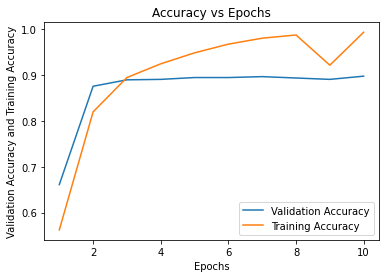

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

###5e-6

In [ ]:

                  
# EPOCHS = 5
model = BertClassifier()
LR = 5e-6
checkpoint_path = '/content/drive/MyDrive/bert/checkpoints/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodel/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8750/8750 [55:34<00:00,  2.62it/s]


Epochs: 1 | Train Loss:  0.144                 | Train Accuracy:  0.662                 | Val Loss:  0.101                 | Val Accuracy:  0.845
Validation Accuracy increased (-inf --> 0.845200).  Saving model ...


100%|██████████| 8750/8750 [56:09<00:00,  2.60it/s]


Epochs: 2 | Train Loss:  0.070                 | Train Accuracy:  0.900                 | Val Loss:  0.067                 | Val Accuracy:  0.898
Validation Accuracy increased (0.845200 --> 0.898200).  Saving model ...


100%|██████████| 8750/8750 [56:07<00:00,  2.60it/s]


Epochs: 3 | Train Loss:  0.038                 | Train Accuracy:  0.953                 | Val Loss:  0.076                 | Val Accuracy:  0.905
Validation Accuracy increased (0.898200 --> 0.905000).  Saving model ...


100%|██████████| 8750/8750 [56:06<00:00,  2.60it/s]


Epochs: 4 | Train Loss:  0.016                 | Train Accuracy:  0.985                 | Val Loss:  0.111                 | Val Accuracy:  0.901


 72%|███████▏  | 6330/8750 [40:32<15:31,  2.60it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, epochbest, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.L

range(5, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [56:26<00:00,  2.58it/s]


Epochs: 5 | Train Loss:  0.009                 | Train Accuracy:  0.992                 | Val Loss:  0.141                 | Val Accuracy:  0.899


100%|██████████| 8750/8750 [56:24<00:00,  2.58it/s]


Epochs: 6 | Train Loss:  0.007                 | Train Accuracy:  0.994                 | Val Loss:  0.167                 | Val Accuracy:  0.903


100%|██████████| 8750/8750 [56:14<00:00,  2.59it/s]


Epochs: 7 | Train Loss:  0.005                 | Train Accuracy:  0.995                 | Val Loss:  0.179                 | Val Accuracy:  0.904


100%|██████████| 8750/8750 [56:12<00:00,  2.59it/s]


Epochs: 8 | Train Loss:  0.005                 | Train Accuracy:  0.996                 | Val Loss:  0.167                 | Val Accuracy:  0.900


100%|██████████| 8750/8750 [56:08<00:00,  2.60it/s]


Epochs: 9 | Train Loss:  0.005                 | Train Accuracy:  0.996                 | Val Loss:  0.194                 | Val Accuracy:  0.900


100%|██████████| 8750/8750 [56:02<00:00,  2.60it/s]


Epochs: 10 | Train Loss:  0.004                 | Train Accuracy:  0.996                 | Val Loss:  0.194                 | Val Accuracy:  0.901


In [ ]:
train_acc=[0.662,0.900,0.953,0.985,0.992,0.994,0.995,0.996,0.996,0.996]
val_acc=[0.845,0.898,0.905,0.901,0.899,0.903,0.904,0.900,0.900,0.901]


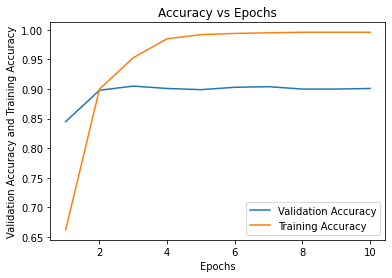

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

###Best from all lr

In [ ]:
# 1e-5
val_acc_1e5=[0.499,0.499,0.502,0.499,0.498,0.504,0.500,0.501,0.499,0.500]
# 1e-6
val_acc_1e6=[0.661,0.876,0.890,0.891,0.895,0.895,0.897,0.894,0.891,0.898]
# 5e-6
val_acc_5e6=[0.845,0.898,0.905,0.901,0.899,0.903,0.904,0.900,0.900,0.901]

#get max validation accuracy for each learning rate
# max_val_acc=[max(val_acc_1e5),max(val_acc_1e6)]
max_val_acc=[max(val_acc_5e6),max(val_acc_1e5),max(val_acc_1e6)]

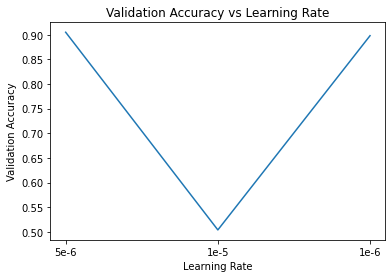

In [ ]:
# plot max validation accuracy for each learning rate
lr=['5e-6','1e-5','1e-6']
# lr=['1e-5','1e-6']
plt.plot(lr, max_val_acc, label='Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate')
plt.show()

###Best Model

In [ ]:
test_labels=[]
pred_labels=[]

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

              test_labels.append(test_label.cpu().numpy()[0])
              test_labels.append(test_label.cpu().numpy()[1])
              pred_labels.append(output.argmax(dim=1).cpu().numpy()[0])
              pred_labels.append(output.argmax(dim=1).cpu().numpy()[1])

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [ ]:
def conf_mat(test_labels,pred_labels):
      conf_matrix = confusion_matrix(test_labels, pred_labels)
      fig, ax = plt.subplots(figsize=(5, 5))
      ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
      for i in range(conf_matrix.shape[0]):
          for j in range(conf_matrix.shape[1]):
              ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

      plt.xlabel('Predictions', fontsize=18)
      plt.ylabel('Actuals', fontsize=18)
      plt.title('Confusion Matrix', fontsize=18)
      plt.show()

In [ ]:
LR

5e-06

In [ ]:
best_epoch

3

In [ ]:
valid_accuracy_max

0.905

In [ ]:
evaluate(model, test_data)

Test Accuracy:  0.909


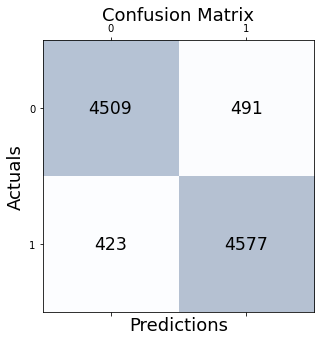

In [ ]:
conf_mat(test_labels,pred_labels)

In [ ]:
def evalscore(tp,tn,fp,fn):
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  specificity=tn/(tn+fp)
  f1=(2*precision*recall)/(precision+recall)

  print(f'F1-score:    {f1:.3f}')
  print(f'Precision:   {precision:.3f}')
  print(f'Recall:      {recall:.3f}')
  print(f'Specificity: {specificity:.3f}')

In [ ]:
tp=4509
tn=4577
fp=423
fn=491

evalscore(tp,tn,fp,fn)

F1-score:    0.908
Precision:   0.914
Recall:      0.902
Specificity: 0.915


# Testing Overall Best Model

In [ ]:
checkpoint_path = '/content/drive/MyDrive/bert1e6/checkpointsacc/check.pt'
best_model = '/content/drive/MyDrive/bert1e6/bestmodelacc/model.pt'
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, best_epoch,valid_accuracy_max, LR = load_model_accuracy(best_model, model, optimizer)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
LR

1e-06

In [ ]:
valid_accuracy_max

0.9114

In [ ]:
best_epoch

6

In [ ]:
def conf_mat(test_labels,pred_labels):
      conf_matrix = confusion_matrix(test_labels, pred_labels)
      fig, ax = plt.subplots(figsize=(5, 5))
      ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
      for i in range(conf_matrix.shape[0]):
          for j in range(conf_matrix.shape[1]):
              ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

      plt.xlabel('Predictions', fontsize=18)
      plt.ylabel('Actuals', fontsize=18)
      plt.title('Confusion Matrix', fontsize=18)
      plt.show()

In [ ]:
test_labels=[]
pred_labels=[]

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

              test_labels.append(test_label.cpu().numpy()[0])
              test_labels.append(test_label.cpu().numpy()[1])
              pred_labels.append(output.argmax(dim=1).cpu().numpy()[0])
              pred_labels.append(output.argmax(dim=1).cpu().numpy()[1])


                # print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
evaluate(model, test_data)

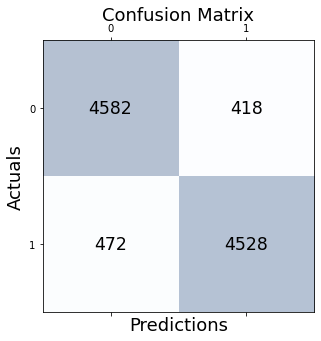

In [ ]:
conf_mat(test_labels,pred_labels)

In [2]:
def evalscore(tp,tn,fp,fn):
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  specificity=tn/(tn+fp)
  f1=(2*precision*recall)/(precision+recall)

  print(f'F1-score:    {f1:.3f}')
  print(f'Precision:   {precision:.3f}')
  print(f'Recall:      {recall:.3f}')
  print(f'Specificity: {specificity:.3f}')

In [9]:
tp=4582
tn=4528
fp=472
fn=418

evalscore(tp,tn,fp,fn)
accuracy=(tp+tn)/(tp+tn+fp+fn)
print(f'Accuracy:    {accuracy:.3f}')

F1-score:    0.911
Precision:   0.907
Recall:      0.916
Specificity: 0.906
Accuracy:    0.911
